In [1]:
install.packages("UpSetR")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(hise)
library(dplyr)
library(reshape2)
library(tidyr)
library(limma)
library(pheatmap)
library(ggplot2)
library(gridExtra)
library(tibble)
library(plotly)
library(readxl)
library(VennDiagram)
library(stringr)
library(grid)
library(UpSetR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: grid

Loading required package: futile.logger



In [4]:
Olink_processed_HC <- readRDS("/home/jupyter/formal_BRIanalysis/Olink_pathway_Mehul/Olink_processed_HC.rds")

## After loading RDS go here

In [5]:
remove_na_columns <- function(df) {
  df_no_nas <- df[, colSums(is.na(df)) == 0]
  return(df_no_nas)
}

In [6]:
Olink_processed_HC1 <- lapply(Olink_processed_HC, remove_na_columns)
Olink_processed_HC2 <- Filter(function(df) nrow(df) > 0 && ncol(df) > 0, Olink_processed_HC1)

In [11]:
combined_results <- c(Olink_processed_HC2)
common_columns <- Reduce(intersect, lapply(combined_results, names))
length(common_columns)

[1] 1433

In [12]:
to_remove <- c(
  "FMR1_OID21233",
  "HK2_OID20065",
  "STXBP3_OID21240",
  "MMP7_OID20087",
  "HNRNPK_OID20051",
  "WASF3_OID20882",
  "PTEN_OID20794",
  "CDC27_OID21238",
  "MTPN_OID20080",
  "STK24_OID20837",
  "CLTA_OID20118",
  "CALB2_OID20801",
  "PADI2_OID20467",
  "AKT3_OID21197",
  "LSM1_OID21210",
  "PAK4_OID20819",
  "SLC27A4_OID20814",
  "IMPA1_OID20907",
  "GSTP1_OID20876",
  "PDP1_OID21176",
  "RCOR1_OID20073",
  "STX16_OID21170",
  "ITGB1BP1_OID21268",
  "HLA-DRA_OID20520",
  "CNPY2_OID20069",
  "TIA1_OID20068",
  "BIRC2_OID21217",
  "ANXA11_OID20583"
)
result_to_remove <- str_extract(to_remove, "([^_]+)")

In [13]:
#remove possible markers identified by Lauren as technically dubious
common_columns <- setdiff(common_columns, result_to_remove)
length(common_columns)

[1] 1405

In [14]:
final_Olink_processed_HC <- lapply(Olink_processed_HC2, function(df) df[, common_columns, drop = FALSE])

## START ANALYSIS

#### LIMMA FIRST year 1 day 0 BR1 vs BR2

In [16]:
dataframe_names <- names(final_Olink_processed_HC)
print(dataframe_names)

 [1] "Flu Year 1 Day 0"              "Flu Year 1 Day 7"             
 [3] "Flu Year 1 Day 90"             "Flu Year 2 Day 0"             
 [5] "Flu Year 2 Day 7"              "Flu Year 1 Pre-Vac 7-12 Weeks"
 [7] "Flu Year 1 Stand-Alone"        "Flu Year 2 Day 90"            
 [9] "Flu Year 3 Day 0"              "Flu Year 3 Day 7"             
[11] "Flu Year 1 Pre-Vac 30 Days"    "Flu Year 2 Stand-Alone"       
[13] "Flu Year 3 Day 90"             "Flu Year 2 Pre-Vac 7-12 Weeks"
[15] "COVID-19 Visit 6"             


In [17]:
## Pick datasets that I would like to be analyzed together
#Use 'Flu Year 1 Day 0'

In [19]:
# Extracting the dataframes. Load all of them separately here. Easier to look at them one at a time later (normalize within timepoints to adjust for batch issues).
yr1_0 <- final_Olink_processed_HC$`Flu Year 1 Day 0`
yr1_7 <- final_Olink_processed_HC$`Flu Year 1 Day 7`
yr1_90 <- final_Olink_processed_HC$`Flu Year 1 Day 90`
yr2_0 <- final_Olink_processed_HC$`Flu Year 2 Day 0`
yr2_7 <- final_Olink_processed_HC$`Flu Year 2 Day 7`
yr2_90 <- final_Olink_processed_HC$`Flu Year 2 Day 90`
yr3_0 <- final_Olink_processed_HC$`Flu Year 3 Day 0`
yr3_7 <- final_Olink_processed_HC$`Flu Year 3 Day 7`
yr3_90 <- final_Olink_processed_HC$`Flu Year 3 Day 90`
yr1_prevac <- final_Olink_processed_HC$`Flu Year 1 Pre-Vac 7-12 Weeks`
yr2_prevac <- final_Olink_processed_HC$`Flu Year 2 Pre-Vac 7-12 Weeks`

In [24]:
#Check alignment
df_list <- list(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac, JAK_STAT)

all_aligned <- all(sapply(2:length(df_list), function(i) identical(names(df_list[[i]]), names(df_list[[1]]))))
if(all_aligned) {
  print("Column names are aligned between all dataframes.")
} else {
  print("Column names are not aligned between all dataframes.")
}

[1] "Column names are aligned between all dataframes."


In [24]:
#Check alignment
df_list <- list(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac, JAK_STAT)

all_aligned <- all(sapply(2:length(df_list), function(i) identical(names(df_list[[i]]), names(df_list[[1]]))))
if(all_aligned) {
  print("Column names are aligned between all dataframes.")
} else {
  print("Column names are not aligned between all dataframes.")
}

[1] "Column names are aligned between all dataframes."


In [25]:
# Combine rows for limma
exprMatrix <- rbind(yr1_0, yr1_prevac, JAK_STAT)
exprMatrix <- t(exprMatrix)

In [26]:
#Load sample Info metadata
sampleInfo <- read.csv("olink-forlimma/sampleInfo2.csv")
rownames(sampleInfo) <- sampleInfo$SampleID
sampleInfo <- sampleInfo[,-1]
sampleInfo <- as.data.frame(sampleInfo)

In [27]:
filtered_meta <- sampleInfo[sampleInfo$Group %in% c("Good_control", "STAT3_GOF"), ]
filtered_meta <- filtered_meta[filtered_meta$Treatment %in% c("None"), ]

In [28]:
common_names <- intersect(colnames(exprMatrix), rownames(filtered_meta))
filtered_meta <- filtered_meta[common_names, ]
test.dat <- exprMatrix[, common_names]
design <- model.matrix(~ Group, data = filtered_meta)
fit <- lmFit(test.dat, design)
fit <- eBayes(fit)
hits <- topTable(fit, coef = 2, p.value = 1, number = 20000)
hits <- as.data.frame(hits)

#filter for adjusted_p < 0.05
filtered_hits <- hits[hits$adj.P.Val < 0.05, ]
hits_STAT3vsCnt <- rownames(filtered_hits)
length(hits_STAT3vsCnt)

#filter for FC>0
pos_filtered_hits <- filtered_hits[filtered_hits$logFC > -50, ] #just take them all for now...
pos_hits_STAT3vsCnt <- rownames(pos_filtered_hits)
length(pos_hits_STAT3vsCnt)

#pos and negative hits
pos_hits <- filtered_hits[filtered_hits$logFC > -0, ]
pos_hits_good <- rownames(pos_hits)
length(pos_hits_good)
neg_hits <- filtered_hits[filtered_hits$logFC < -0, ]
neg_hits_good <- rownames(neg_hits)
length(neg_hits_good)

[1] 376

[1] 376

[1] 299

[1] 77

In [29]:
pos_filtered_hits

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACTN4,3.628142,-0.04017413,13.329226,6.134348e-27,8.618759e-24,50.45293
SEMA7A,2.538949,0.34143566,10.804528,2.576964e-20,1.810317e-17,35.56949
SIGLEC6,2.947830,0.67282343,10.683248,5.350239e-20,2.505695e-17,34.85590
SIGLEC10,2.940487,0.60213881,9.777732,1.209575e-17,4.248632e-15,29.56051
IL2RA,3.094125,0.61599930,9.606250,3.346592e-17,9.403924e-15,28.56650
TNFRSF13B,3.058356,0.13804301,8.705852,6.541897e-15,1.531894e-12,23.41570
NOS3,3.601409,-0.10981503,8.464094,2.632915e-14,5.284637e-12,22.05703
CCL21,2.368732,1.15889685,8.168560,1.420225e-13,2.494271e-11,20.41334
PHOSPHO1,-1.971793,0.02601538,-8.102600,2.063119e-13,3.220757e-11,20.04928


In [30]:
#Outlier test for STAT3 samples
exclude_columns = c('BY1001', 'TR1001')
row_means = apply(test.dat[, !colnames(test.dat) %in% exclude_columns], 1, mean)
row_sds = apply(test.dat[, !colnames(test.dat) %in% exclude_columns], 1, sd)

# Extract the values for BY1001 and TR1001
BY1001_values = test.dat[, 'BY1001']
TR1001_values = test.dat[, 'TR1001']

# Calculate the z-scores for BY1001 relative to other samples
z_scores = (BY1001_values - row_means) / row_sds
# 2SD
outlier_genes = names(which(abs(z_scores) > 2))
# Determine the direction
direction = ifelse(BY1001_values[outlier_genes] > row_means[outlier_genes], "above", "below")
# Combine genes and directions
outliers_with_direction = data.frame(Gene = outlier_genes, Direction = direction)
# Subset for genes that are "above"
genes_above_BY1001 = outliers_with_direction$Gene[outliers_with_direction$Direction == 'above']
genes_above_BY1001 <- as.list(genes_above_BY1001)
# Subset for genes that are "below"
genes_below_BY1001 = outliers_with_direction$Gene[outliers_with_direction$Direction == 'below']
genes_below_BY1001 <- as.list(genes_below_BY1001)


# Calculate the z-scores for BY1001 relative to other samples
z_scores = (TR1001_values - row_means) / row_sds
# 2SD
outlier_genes = names(which(abs(z_scores) > 2))
# Determine the direction
direction = ifelse(TR1001_values[outlier_genes] > row_means[outlier_genes], "above", "below")
# Combine genes and directions
outliers_with_direction = data.frame(Gene = outlier_genes, Direction = direction)
# Subset for genes that are "above"
genes_above_TR1001 = outliers_with_direction$Gene[outliers_with_direction$Direction == 'above']
genes_above_TR1001 <- as.list(genes_above_TR1001)
# Subset for genes that are "below"
genes_below_TR1001 = outliers_with_direction$Gene[outliers_with_direction$Direction == 'below']
genes_below_TR1001 <- as.list(genes_below_TR1001)

In [34]:
class(test.dat)

[1] "matrix" "array"

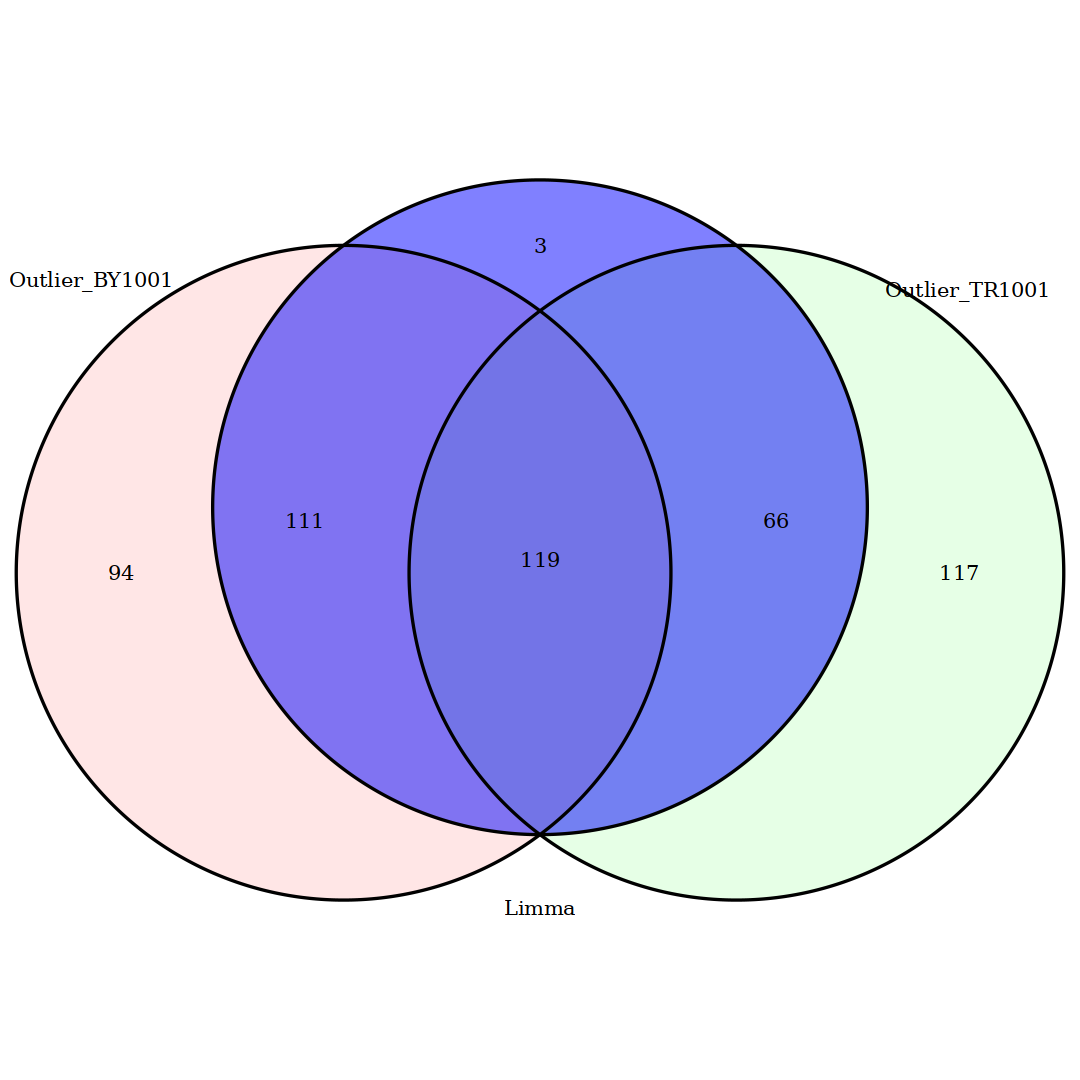

In [21]:
options(repr.plot.width=9, repr.plot.height=9)

set1 <- unlist(pos_hits_good)
set2 <- unlist(genes_above_BY1001)
set3 <- unlist(genes_above_TR1001)

# Create semi-transparent colors using the rgb function
semi_transparent_red <- rgb(1, 0, 0, 0.2)  # Red with 50% opacity
semi_transparent_green <- rgb(0, 1, 0, 0.2)  # Green with 50% opacity

#PNG file
#png("O-link Analysis/venn_diagram_upregulated_STAT3.png", width = 800, height = 800)

# Create a Venn diagram
venn.plot <- venn.diagram(
  x = list(Set1 = set1, Set2 = set2, Set3 = set3),
  category.names = c("Limma", "Outlier_BY1001", "Outlier_TR1001"),
  output = FALSE,  # Set output to FALSE for on-screen plotting
  scaled = TRUE,
  filename = NULL,
  fill = c("blue", semi_transparent_red, semi_transparent_green)  # Semi-transparent colors for other sets
)

# Display the plot
grid.draw(venn.plot)

# Close the device
#dev.off()

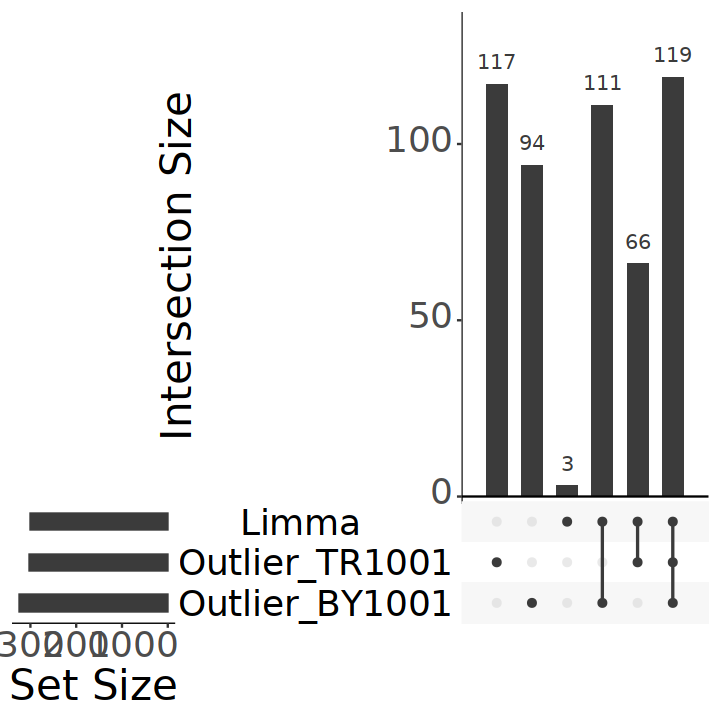

In [22]:
options(repr.plot.width=6, repr.plot.height=6)

list_of_sets <- list(
  Limma = set1,
  Outlier_BY1001 = set2,
  Outlier_TR1001 = set3
)

#PNG file
#png("O-link Analysis/upsetr_upregulated_STAT3.png", width = 800, height = 800)

# Create the UpSet plot
upset(fromList(list_of_sets), sets = c("Limma", "Outlier_BY1001", "Outlier_TR1001"),text.scale = c(3,3,3,3,3))

# Close the device
#dev.off()

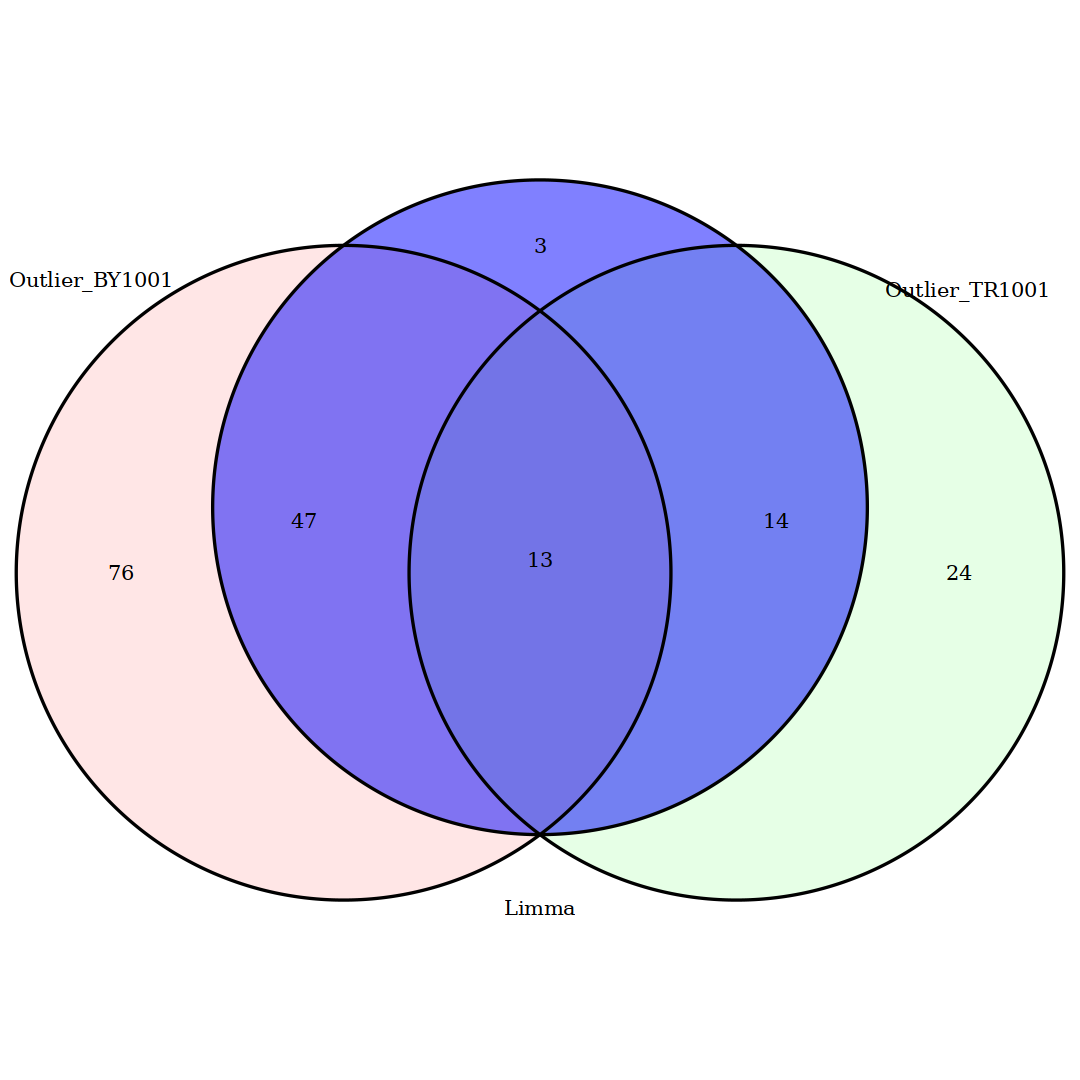

In [23]:
options(repr.plot.width=9, repr.plot.height=9)

set1 <- unlist(neg_hits_good)
set2 <- unlist(genes_below_BY1001)
set3 <- unlist(genes_below_TR1001)

# Create semi-transparent colors using the rgb function
semi_transparent_red <- rgb(1, 0, 0, 0.2)  # Red with 50% opacity
semi_transparent_green <- rgb(0, 1, 0, 0.2)  # Green with 50% opacity

#PNG file
#png("O-link Analysis/venn_diagram_downregulated_STAT3.png", width = 800, height = 800)

# Create a Venn diagram
venn.plot <- venn.diagram(
  x = list(Set1 = set1, Set2 = set2, Set3 = set3),
  category.names = c("Limma", "Outlier_BY1001", "Outlier_TR1001"),
  output = FALSE,  # Set output to FALSE for on-screen plotting
  scaled = TRUE,
  filename = NULL,
  fill = c("blue", semi_transparent_red, semi_transparent_green)  # Semi-transparent colors for other sets
)

# Display the plot
grid.draw(venn.plot)

# Close the device
#dev.off()

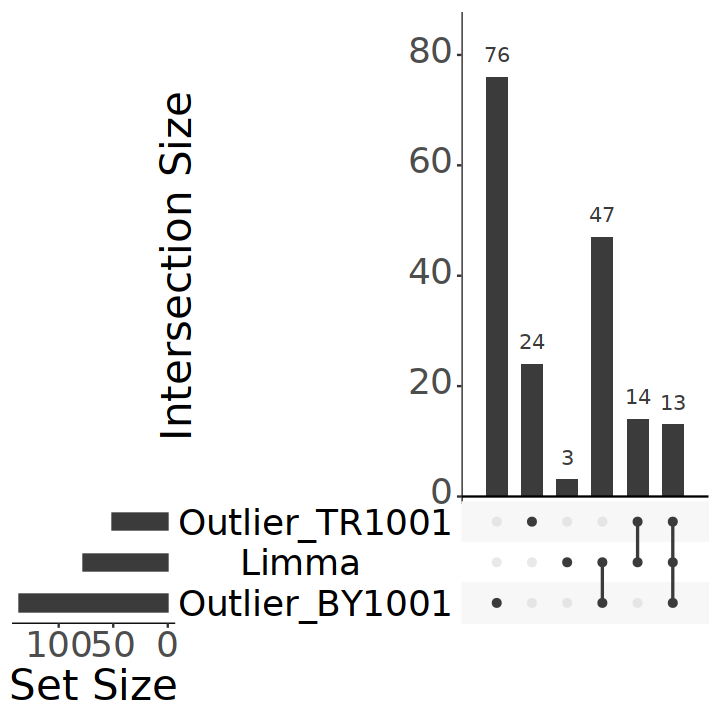

In [24]:
options(repr.plot.width=6, repr.plot.height=6)
list_of_sets <- list(
  Limma = set1,
  Outlier_BY1001 = set2,
  Outlier_TR1001 = set3
)

#PNG file
#png("O-link Analysis/upsetr_downregulated_STAT3.png", width = 800, height = 800)

# Create the UpSet plot
upset(fromList(list_of_sets), sets = c("Limma", "Outlier_BY1001", "Outlier_TR1001"),text.scale = c(3,3,3,3,3))

# Close the device
#dev.off()

In [61]:
## Do it for STAT1 as well
filtered_meta <- sampleInfo[sampleInfo$Group %in% c("Good_control", "STAT1_GOF"), ]
filtered_meta <- filtered_meta[filtered_meta$Treatment %in% c("None"), ]
common_names <- intersect(colnames(exprMatrix), rownames(filtered_meta))
filtered_meta <- filtered_meta[common_names, ]
test.dat <- exprMatrix[, common_names]
design <- model.matrix(~ Group, data = filtered_meta)
fit <- lmFit(test.dat, design)
fit <- eBayes(fit)
hits <- topTable(fit, coef = 2, p.value = 1, number = 20000)
hits <- as.data.frame(hits)
filtered_hits <- hits[hits$adj.P.Val < 0.05, ]
hits_STAT1vsCnt <- rownames(filtered_hits)
length(hits_STAT1vsCnt)

pos_filtered_hits <- filtered_hits[filtered_hits$logFC > -50, ] #just take them all for now...
pos_hits_STAT1vsCnt <- rownames(pos_filtered_hits)
length(pos_hits_STAT1vsCnt)

[1] 713

[1] 713

In [26]:
## SLEA function - from Aarthi Talla
# do SLEA (Sample Level Enrichment Analysis) function(z-score per sample)
doSLEA <- function(expressionSet, geneSet) {
  # scale expression
  exprsMat <- expressionSet
  exprsMat <- t(scale(t(exprsMat)))
  # extract expression of leGenes of each geneset
  comm <- intersect(geneSet, rownames(expressionSet))
  gsDF <- exprsMat[comm, ]
  # calculate mean expression per sample
  gsM <- colMeans(gsDF)
  # extract random markers of size of the geneSet from full probeset and calculate mean
  # and perform this for 'n' permutations
  nperm <- lapply(1:1000, function(j) {
    # set seed for every permutation
    set.seed(j)
    rGSDF <- exprsMat[sample.int(nrow(exprsMat),length(comm)), ]
    rGSM <- colMeans(rGSDF)
    return(value = rGSM)
  })
  permDF <- do.call(rbind, nperm)
  zscore <- (gsM - colMeans(permDF)) / apply(permDF,2,sd)
  sleaDF <- zscore %>% as.data.frame()
  return(value = sleaDF)
}

In [27]:
uniqueInSTAT1 <- setdiff(pos_hits_STAT1vsCnt, pos_hits_STAT3vsCnt)
uniqueInSTAT3 <- setdiff(pos_hits_STAT3vsCnt, pos_hits_STAT1vsCnt)

In [28]:
le1 <- list(
  pos_hits_STAT1vsCnt = pos_hits_STAT1vsCnt,
  pos_hits_STAT3vsCnt = pos_hits_STAT3vsCnt,
  uniqueInSTAT1 = uniqueInSTAT1, 
  uniqueInSTAT3 = uniqueInSTAT3
)

In [29]:
to_filter <- sampleInfo[sampleInfo$Group %in% c("Good_control", "STAT1_GOF", "STAT3_GOF", "STAT5b_GOF"), ]
common_names_meta <- intersect(rownames(to_filter), colnames(exprMatrix))
the_file <- exprMatrix[, common_names_meta]
mat <- the_file

In [30]:
sleaLS <- lapply(1:length(le1), function(l) {
  expressionSet = mat
  geneSet <- le1[[l]] %>% strsplit(",") %>% unlist(.)
  sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
  names(sDF) <- names(le1[l])
  return(value = sDF)
})
sleaDF <- do.call(cbind, sleaLS)
sleaDF <- sleaDF %>% t() %>% as.data.frame()

t_sleaDF <- t(sleaDF)

t_sleaDF <- as.data.frame(t_sleaDF)
head(t_sleaDF)

,pos_hits_STAT1vsCnt,pos_hits_STAT3vsCnt,uniqueInSTAT1,uniqueInSTAT3
,<dbl>,<dbl>,<dbl>,<dbl>
UP1004,-6.427982,6.2322533,-8.310447,5.3149560
UP1002,-3.610851,-1.8114371,-1.470098,0.7064806
UP1006,-8.985952,4.1468544,-8.540736,5.8063361
UP1003,-5.626353,0.9870753,-5.250764,1.9592371
UP1013,-4.940597,0.9371213,-4.354650,2.4865546
UP1007,-7.935571,3.3106635,-8.924722,3.2139177


In [31]:
merge_slea_meta <- merge(t_sleaDF, sampleInfo, by = "row.names", all = TRUE)
merge_slea_meta <- na.omit(merge_slea_meta)

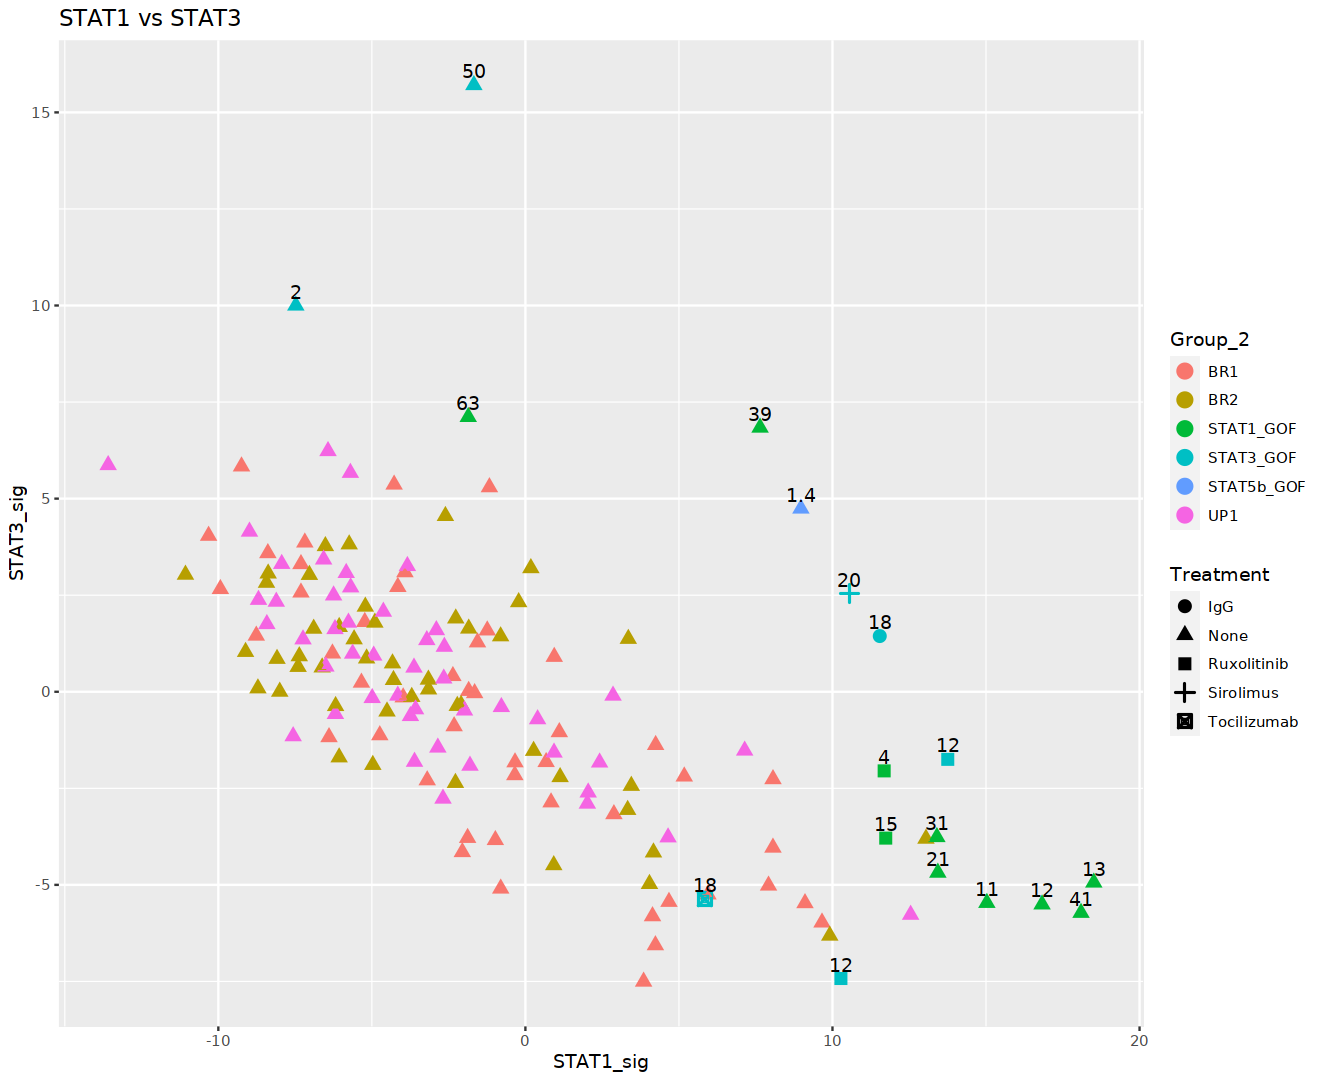

In [32]:
options(repr.plot.width=11, repr.plot.height=9)

#PNG file
#png("O-link Analysis/STAT1vsSTAT3_HC_patients1.png", width = 1000, height = 800)

plot1 <- ggplot(merge_slea_meta, aes(x = pos_hits_STAT1vsCnt, y = pos_hits_STAT3vsCnt, color = Group_2, shape = Treatment)) +
geom_point(size = 3, stroke = 1, aes(fill = Group)) +
  geom_point() +
  geom_text(data = subset(merge_slea_meta, Group != "Good_control"), aes(label = as.character(Age)), vjust = -0.5, hjust = 0.5, color = "black") +
  scale_fill_manual(name = "Group", values = c("Control" = "red", "OtherGroup" = "blue")) +
  labs(title = "STAT1 vs STAT3",
       x = "STAT1_sig", y = "STAT3_sig")
plot1

#dev.off()

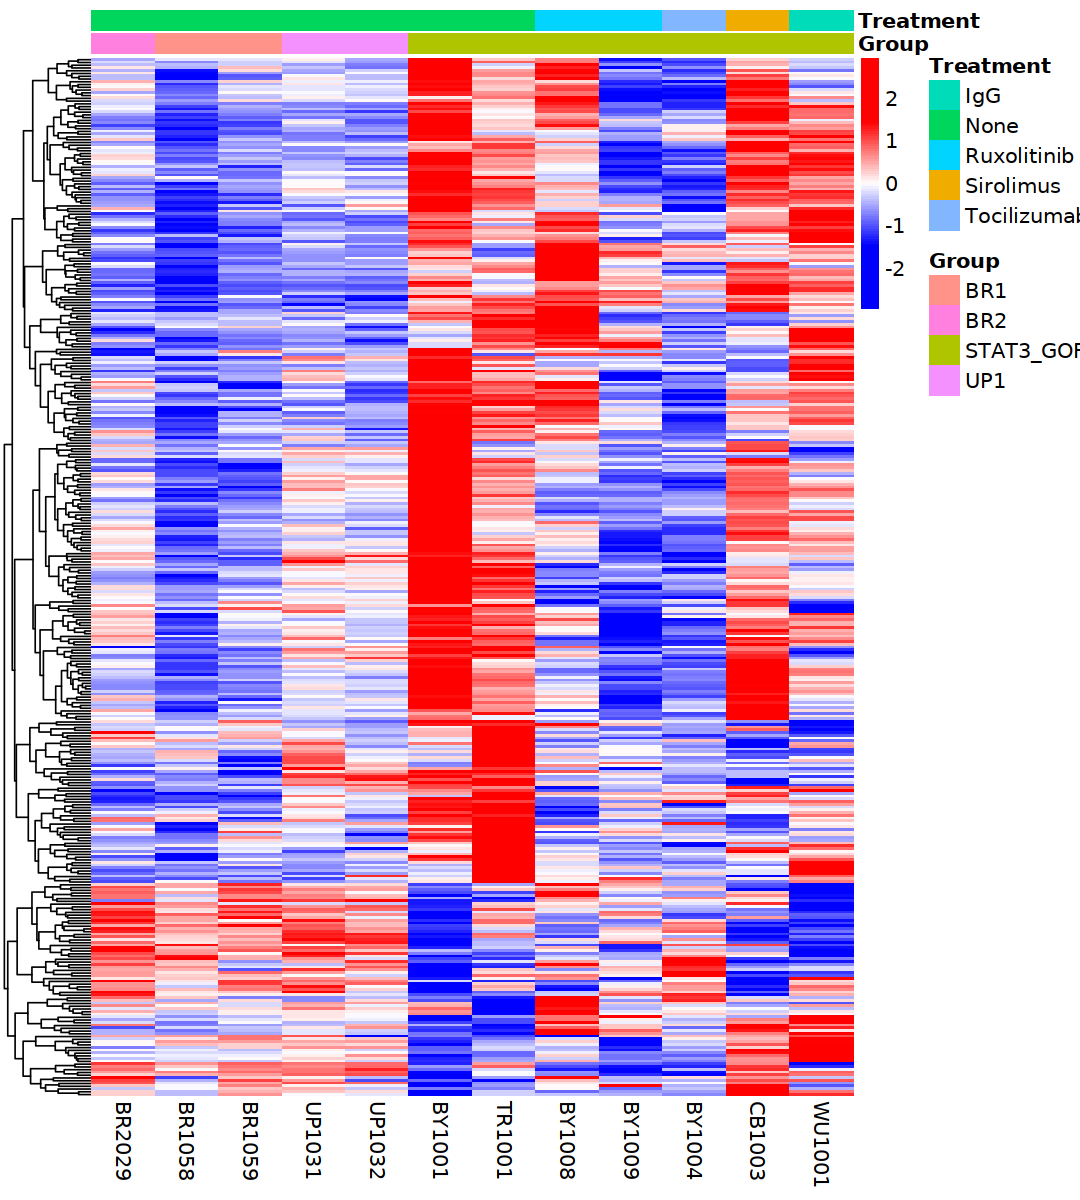

In [41]:
#heatmap. STAT3 vs ALL
options(repr.plot.width=9, repr.plot.height=10)
data_onlypatients <- exprMatrix
desired_order <- c("BR2029", "BR1058", "BR1059","UP1031", "UP1032", "BY1001", "TR1001", "BY1008", "BY1009", "BY1004", "CB1003", "WU1001")
data_onlypatients <- data_onlypatients[, desired_order]
colorPalette <- c("blue", "blue", "white", "red", "red")
colorPalette <- colorRampPalette(colors = colorPalette)(100)

# Match the column names with Group_2 and Treatment values
group_2_annotation <- sampleInfo[match(colnames(data_onlypatients), rownames(sampleInfo)), "Group_2"]
treatment_annotation <- sampleInfo[match(colnames(data_onlypatients), rownames(sampleInfo)), "Treatment"]

# Create an annotation dataframe for pheatmap
annotation_col <- data.frame(Group = group_2_annotation, Treatment = treatment_annotation)
rownames(annotation_col) <- colnames(data_onlypatients)

# Create the heatmap with annotations
pheatmap(data_onlypatients[pos_hits_STAT3vsCnt, ], 
         scale = "row", 
         color = colorPalette, 
         cluster_cols = FALSE, 
         border_color = "white", 
         fontsize = 12,
         show_rownames = FALSE,
         annotation_col = annotation_col)
#         filename = "O-link Analysis/STAT3vsALL.png")

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


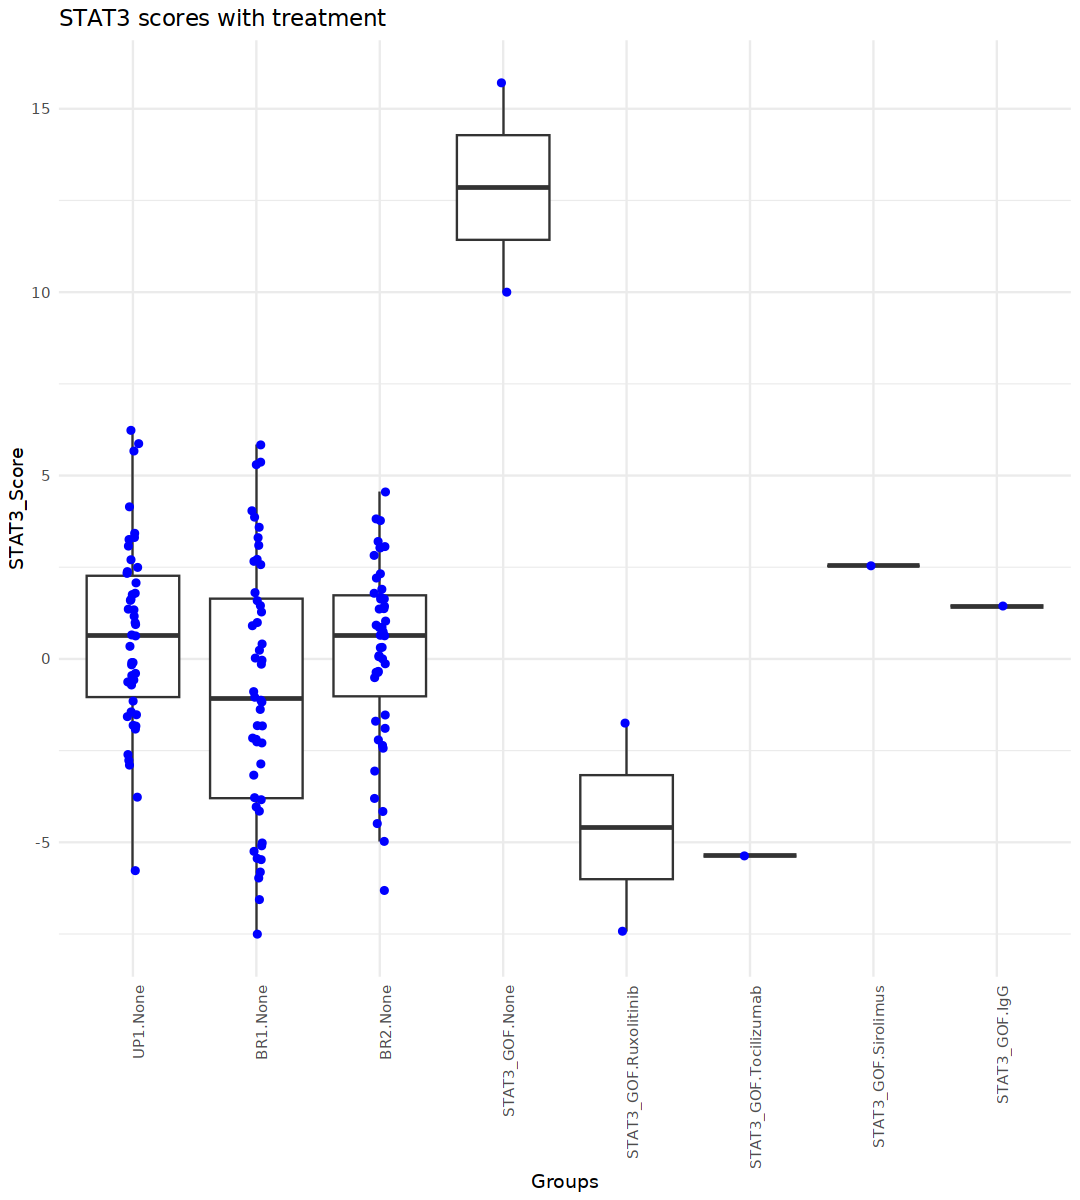

In [34]:
merge_slea_meta <- merge(t_sleaDF, sampleInfo, by = "row.names", all = TRUE)
merge_slea_meta_clean <- subset(merge_slea_meta, Group != "Control" & Group != "Bad_STAT1_GOF" & Group != "STAT1_GOF" & Group != "STAT5b_GOF")
merge_slea_meta_clean$Groups <- interaction(merge_slea_meta_clean$Group_2, merge_slea_meta_clean$Treatment)

ordered_levels <- c("UP1.None", "BR1.None", "BR2.None", "STAT3_GOF.None", "STAT3_GOF.Ruxolitinib", "STAT3_GOF.Tocilizumab", "STAT3_GOF.Sirolimus", "STAT3_GOF.IgG")
merge_slea_meta_clean$Groups <- factor(merge_slea_meta_clean$Groups, levels = ordered_levels)

#PNG file
#png("O-link Analysis/boxplot_STAT3_w_Tx.png", width = 500, height = 600)

ggplot(merge_slea_meta_clean, aes(x = Groups, y = pos_hits_STAT3vsCnt)) +
  geom_boxplot(outlier.shape = NA) +  # Hide the default outliers
  geom_point(aes(color = "Data Points"), position = position_jitter(width = 0.05)) +
  theme_minimal() +
  labs(title = "STAT3 scores with treatment", y = "STAT3_Score") +
  scale_color_manual(values = "blue") +
  guides(color = FALSE) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

#dev.off()

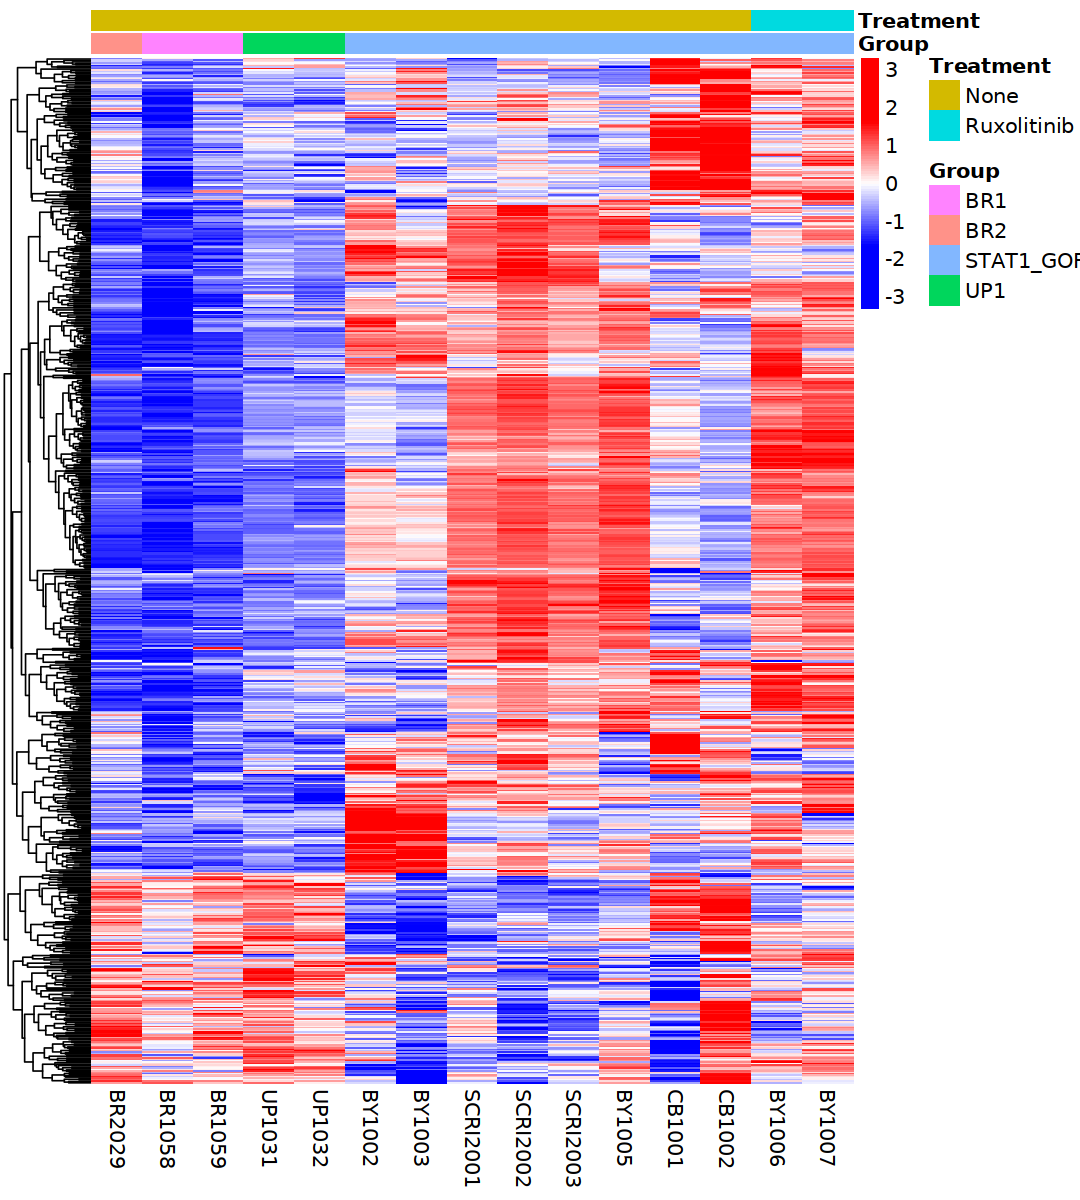

In [36]:
#heatmap. STAT1 vs ALL
options(repr.plot.width=9, repr.plot.height=10)
data_onlypatients <- exprMatrix
desired_order <- c("BR2029", "BR1058", "BR1059","UP1031", "UP1032", "BY1002", "BY1003", "SCRI2001", "SCRI2002", "SCRI2003", "BY1005", "CB1001", "CB1002", "BY1006", "BY1007")
data_onlypatients <- data_onlypatients[, desired_order]
colorPalette <- c("blue", "blue", "white", "red", "red")
colorPalette <- colorRampPalette(colors = colorPalette)(100)

# Match the column names with Group_2 and Treatment values
group_2_annotation <- sampleInfo[match(colnames(data_onlypatients), rownames(sampleInfo)), "Group_2"]
treatment_annotation <- sampleInfo[match(colnames(data_onlypatients), rownames(sampleInfo)), "Treatment"]

# Create an annotation dataframe for pheatmap
annotation_col <- data.frame(Group = group_2_annotation, Treatment = treatment_annotation)
rownames(annotation_col) <- colnames(data_onlypatients)

# Create the heatmap with annotations
pheatmap(data_onlypatients[pos_hits_STAT1vsCnt, ], 
         scale = "row", 
         color = colorPalette, 
         cluster_cols = FALSE, 
         border_color = "white", 
         fontsize = 12,
         show_rownames = FALSE,
         annotation_col = annotation_col)
     #    filename = "O-link Analysis/STAT1vsALL.png")

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


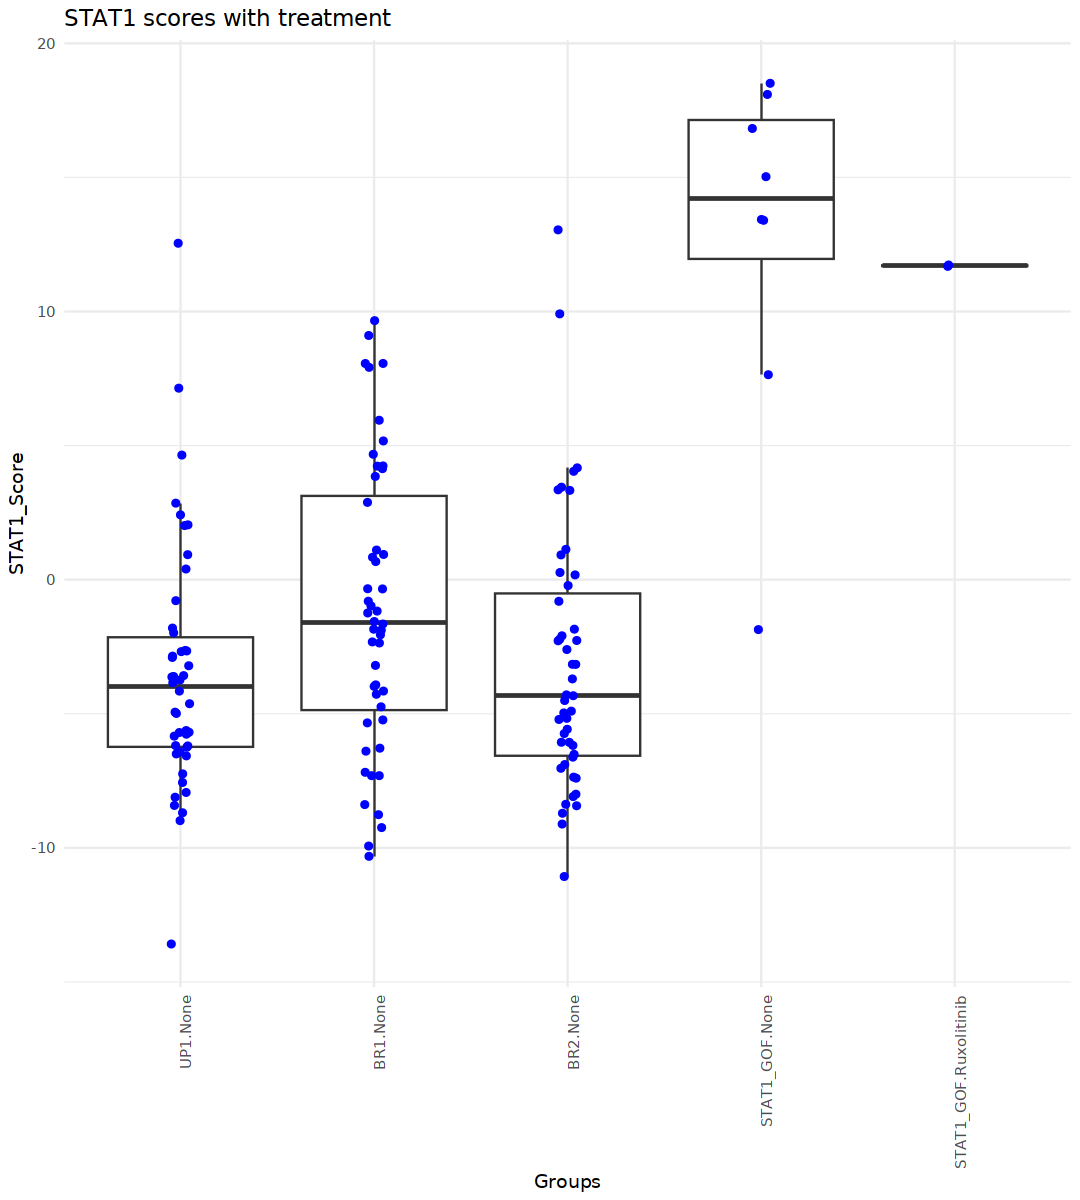

In [37]:
merge_slea_meta <- merge(t_sleaDF, sampleInfo, by = "row.names", all = TRUE)
merge_slea_meta_clean <- subset(merge_slea_meta, Group != "Control" & Group != "Bad_STAT1_GOF" & Group != "STAT3_GOF" & Group != "STAT5b_GOF")
merge_slea_meta_clean$Groups <- interaction(merge_slea_meta_clean$Group_2, merge_slea_meta_clean$Treatment)

ordered_levels <- c("UP1.None", "BR1.None", "BR2.None", "STAT1_GOF.None", "STAT1_GOF.Ruxolitinib")
merge_slea_meta_clean$Groups <- factor(merge_slea_meta_clean$Groups, levels = ordered_levels)

#PNG file
#png("O-link Analysis/boxplot_STAT1_w_Tx.png", width = 400, height = 600)

ggplot(merge_slea_meta_clean, aes(x = Groups, y = pos_hits_STAT1vsCnt)) +
  geom_boxplot(outlier.shape = NA) +  # Hide the default outliers
  geom_point(aes(color = "Data Points"), position = position_jitter(width = 0.05)) +
  theme_minimal() +
  labs(title = "STAT1 scores with treatment", y = "STAT1_Score") +
  scale_color_manual(values = "blue") +
  guides(color = FALSE) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

#dev.off()

Warning message:
“Removed 112 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 112 rows containing missing values (`geom_point()`).”


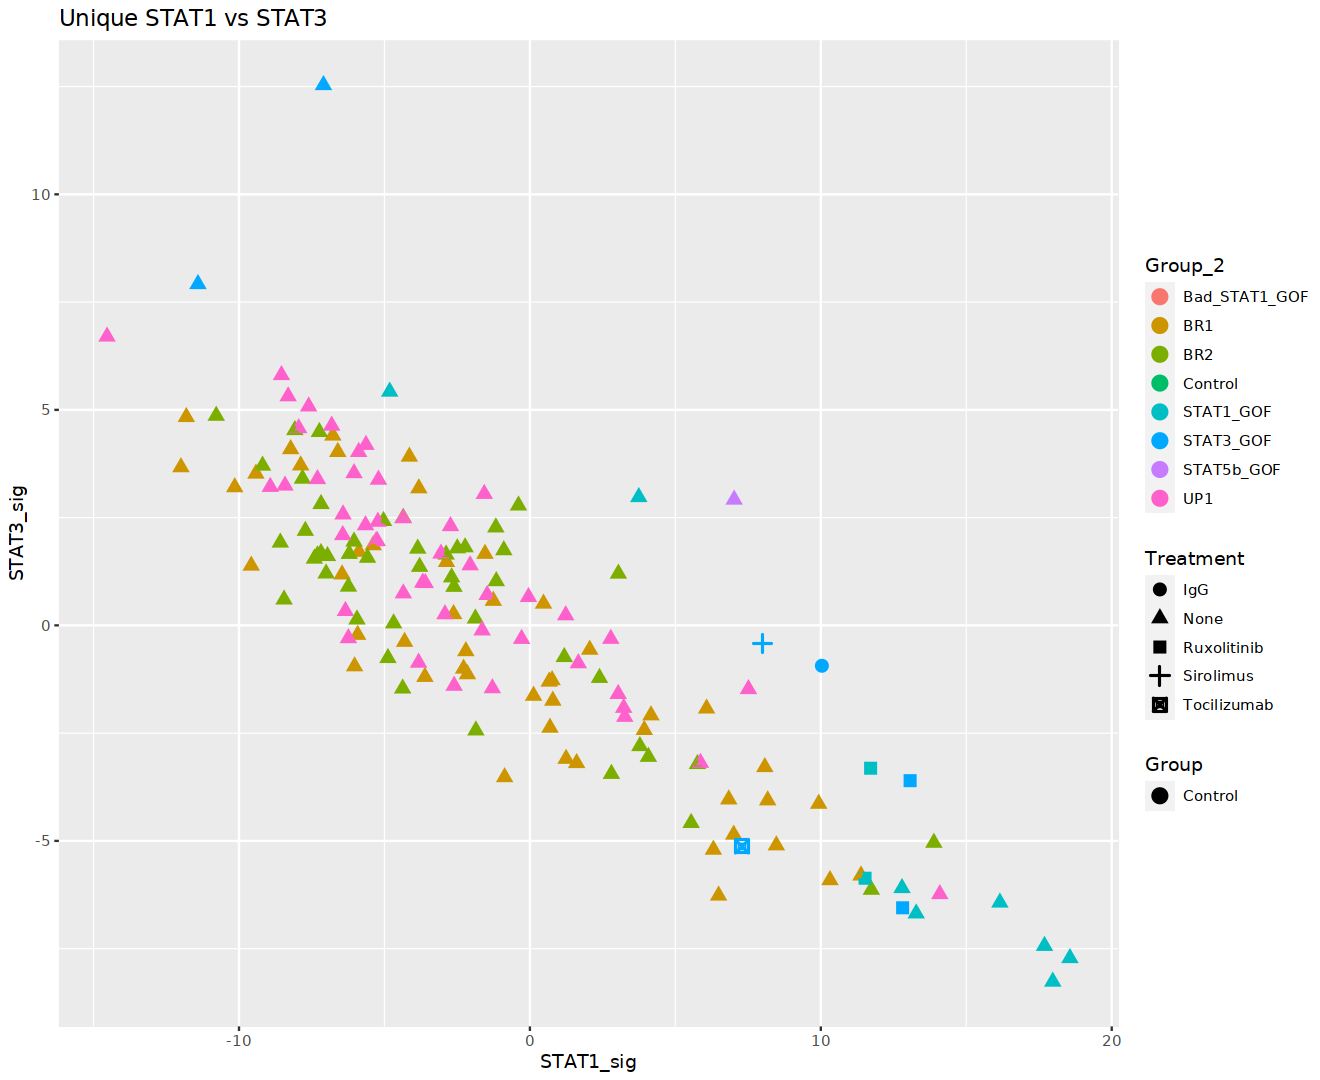

In [38]:
options(repr.plot.width=11, repr.plot.height=9)
plot1 <- ggplot(merge_slea_meta, aes(x = uniqueInSTAT1, y = uniqueInSTAT3, color = Group_2, shape = Treatment)) +
geom_point(size = 3, stroke = 1, aes(fill = Group)) +
  geom_point() +
 scale_fill_manual(name = "Group", values = c("Control" = "red", "OtherGroup" = "blue")) +
  labs(title = "Unique STAT1 vs STAT3",
       x = "STAT1_sig", y = "STAT3_sig")
plot1

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


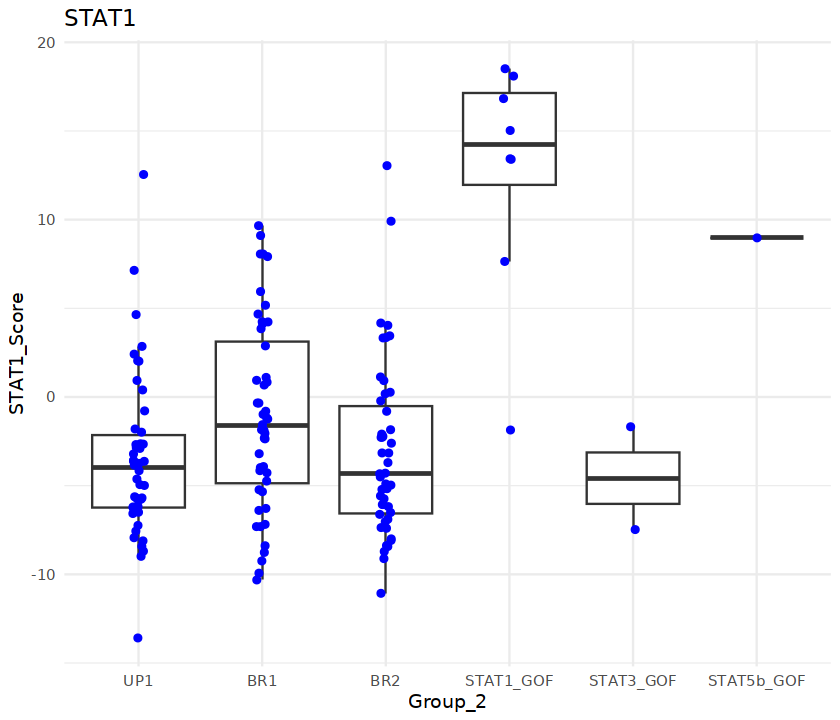

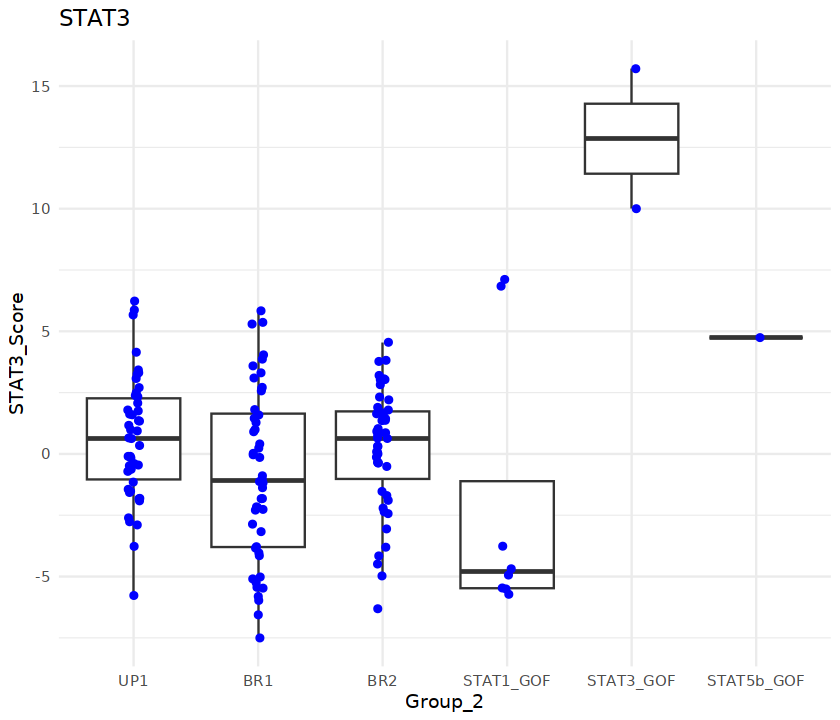

In [39]:
#Boxplot of untreated JAK STAT patients
merge_slea_meta_clean <- subset(merge_slea_meta, Group != "Control" & Group != "Bad_STAT1_GOF" & Treatment != "Sirolimus"  & Treatment != "Ruxolitinib" & Treatment != "IgG" & Treatment != "Tocilizumab")

ordered_levels <- c("UP1", "BR1", "BR2", "STAT1_GOF", "STAT3_GOF", "STAT5b_GOF")
merge_slea_meta_clean$Group_2 <- factor(merge_slea_meta_clean$Group_2, levels = ordered_levels)

#PNG file
#png("O-link Analysis/boxplot_STAT1_STAT3_STAT1score.png", width = 400, height = 400)

options(repr.plot.width=7, repr.plot.height=6)
ggplot(merge_slea_meta_clean, aes(x = Group_2, y = pos_hits_STAT1vsCnt)) +
  geom_boxplot(outlier.shape = NA) +  # Hide the default outliers
  geom_point(aes(color = "Data Points"), position = position_jitter(width = 0.05)) +
  theme_minimal() +
  labs(title = "STAT1", y = "STAT1_Score") +
  scale_color_manual(values = "blue") +
  guides(color = FALSE)

#dev.off()

#PNG file
#png("O-link Analysis/boxplot_STAT1_STAT3_STAT3score.png", width = 400, height = 400)

ggplot(merge_slea_meta_clean, aes(x = Group_2, y = pos_hits_STAT3vsCnt)) +
  geom_boxplot(outlier.shape = NA) +  # Hide the default outliers
  geom_point(aes(color = "Data Points"), position = position_jitter(width = 0.05)) +
  theme_minimal() +
  labs(title = "STAT3", y = "STAT3_Score") +
  scale_color_manual(values = "blue") +
  guides(color = FALSE)

#dev.off()

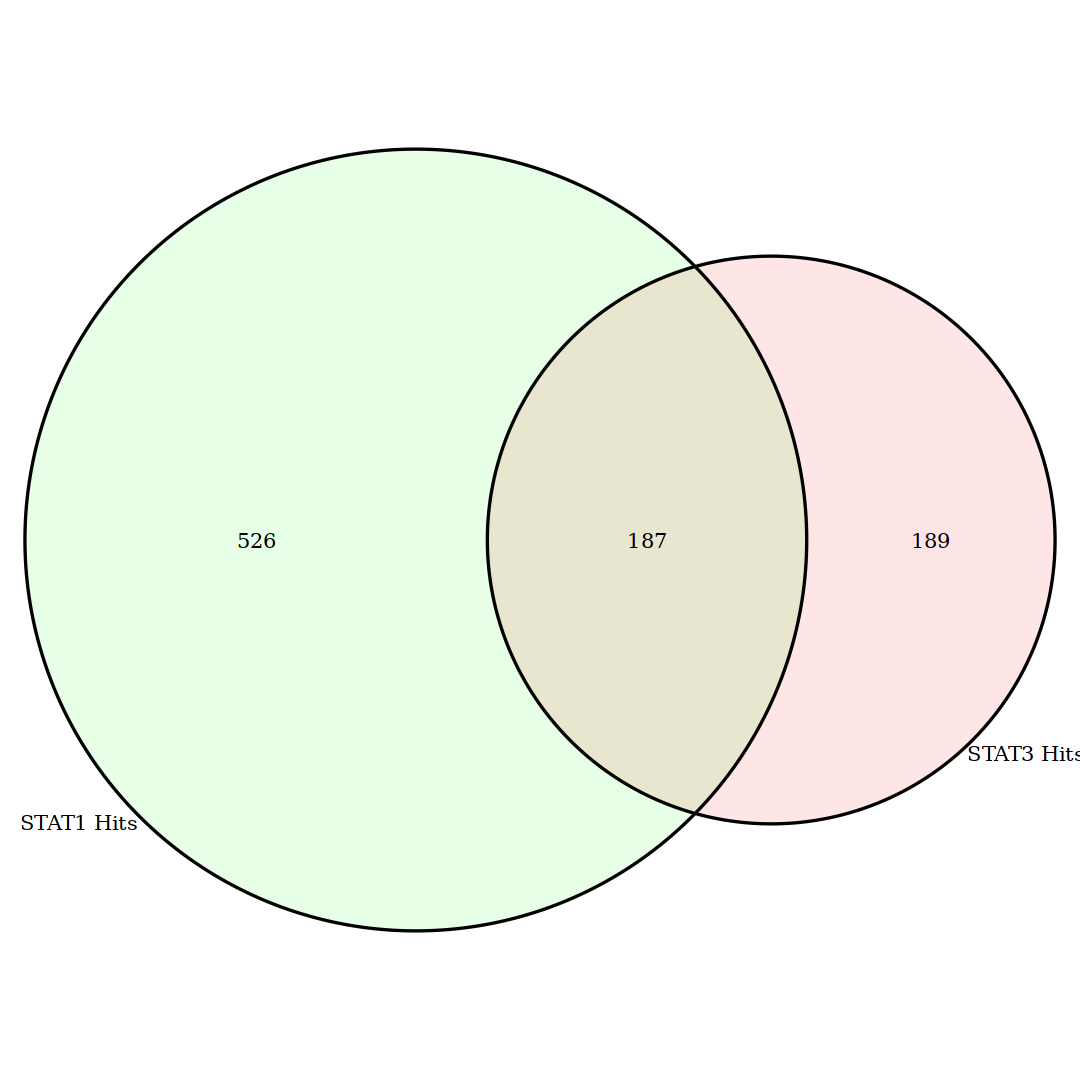

In [40]:
options(repr.plot.width=9, repr.plot.height=9)

set1 <- unlist(pos_hits_STAT3vsCnt)
set2 <- unlist(pos_hits_STAT1vsCnt)

# Create semi-transparent colors using the rgb function
semi_transparent_red <- rgb(1, 0, 0, 0.2)  # Red with 50% opacity
semi_transparent_green <- rgb(0, 1, 0, 0.2)  # Green with 50% opacity

#PNG file
#png("O-link Analysis/venn_diagram_STAT1vsSTAT3hits.png", width = 800, height = 800)

# Create a Venn diagram
venn.plot <- venn.diagram(
  x = list(Set1 = set1, Set2 = set2),
  category.names = c("STAT3 Hits", "STAT1 Hits"),
  output = FALSE,  # Set output to FALSE for on-screen plotting
  scaled = TRUE,
  filename = NULL,
  fill = c(semi_transparent_red, semi_transparent_green)  # Semi-transparent colors for other sets
)

# Display the plot
grid.draw(venn.plot)

# Close the device
#dev.off()

#### Plot Flu year 1 data with limma hits

In [74]:
#load year 1 flu data
df_list <- list(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac)

#### Plot yr1 and yr2 data (without 7 day post flu) for HCs

In [108]:
#Check alignment
df_list <- list(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac, yr3_0, yr3_7, yr3_90)

all_aligned <- all(sapply(2:length(df_list), function(i) identical(names(df_list[[i]]), names(df_list[[1]]))))
if(all_aligned) {
  print("Column names are aligned between all dataframes.")
} else {
  print("Column names are not aligned between all dataframes.")
}

[1] "Column names are aligned between all dataframes."


In [116]:
# Combine rows for limma
exprMatrix_all <- rbind(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac)
exprMatrix_all <- t(exprMatrix_all)